In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from RobotSim373 import *

Version:  0.0.32


In [3]:
def build(robot):
    box1=Box(robot,x=3,y=9.5,name="right")
    box2=Box(robot,x=3,y=11.5,name="left")    
    
    connect(box1,box2,"weld")
    
    disk1=Disk(robot,x=2,y=10.5,name="center")
    
    connect(disk1,box1,"distance")
    connect(disk1,box2,"distance")    

In [4]:
def forward(t,robot):
    robot['left'].F=0.1
    robot['right'].F=0.1
    robot.message='Forward'
    return True

def backward(t,robot):
    robot['left'].F=-0.1
    robot['right'].F=-0.1
    robot.message='Backward'
    return True

def until_close(t,robot):
    distance=robot['center'].read_distance()
    robot.message='Until Close'
    if distance<10:
        return True
    
def until_far(t,robot):
    distance=robot['center'].read_distance()
    robot.message='Until Far'
    if distance>10:
        return True
    


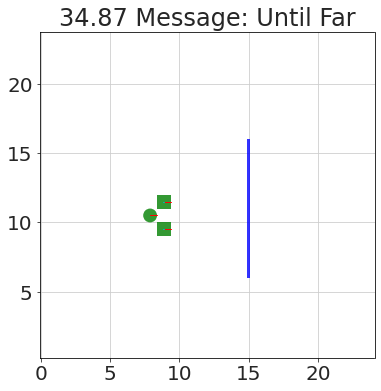

In [5]:
env=Environment(24,24)
robot=Robot(env)
build(robot)

Box(env,x=15,y=11,width=0.2,height=10)


run_sim(env,[forward,until_close,backward,until_far],
        figure_width=6,
       total_time=80,
       dt_display=0.5,  # make this larger for a faster display
       )

## rewrite with finite state machine

In [6]:
def forward(t,robot):
    robot['left'].F=0.1
    robot['right'].F=0.1
    return True

def backward(t,robot):
    robot['left'].F=-0.1
    robot['right'].F=-0.1
    return True

def until_close(t,robot):
    distance=robot['center'].read_distance()
    if distance<10:
        return True
    
def until_far(t,robot):
    distance=robot['center'].read_distance()
    if distance>10:
        return True
    
    
def monitor(t,robot):
    robot.message=robot.controller.current_state


In [13]:
state_machine=StateMachine(
    (forward,'until_close'),
    (until_far,'forward'),
    (backward,'until_far'),
    (until_close,'backward'),
)


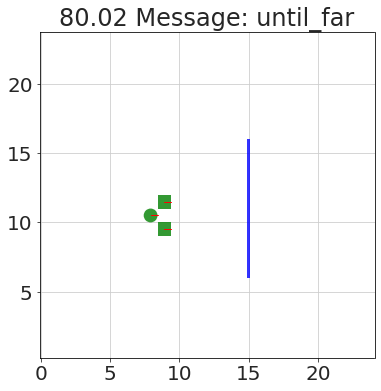

In [14]:
env=Environment(24,24)
robot=Robot(env)
build(robot)

robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

Box(env,x=15,y=11,width=0.2,height=10)


run_sim(env,robot.controller,
        figure_width=6,
       total_time=80,
       dt_display=0.5,  # make this larger for a faster display
       )

# a more complex example

- have the robot approach until a certain distance
- look a bit left and right to see where the wall ends
- if the wall ends to the right, then turn right and go forward
- if the wall ends to the left, then turn left and go forward
- if the wall doesn't end, then go backward

### first, introduce a friction environment -- makes stopping easier

In [7]:
def forward(t,robot):
    robot['left'].F=4
    robot['right'].F=4
    return True

def backward(t,robot):
    robot['left'].F=-4
    robot['right'].F=-4
    return True

def stop(t,robot):
    robot['left'].F=0
    robot['right'].F=0
    return True

def until_close(t,robot):
    distance=robot['center'].read_distance()
    if distance<6:
        return True
    
def until_far(t,robot):
    distance=robot['center'].read_distance()
    if distance>10:
        return True
    
def look_left(t,robot):
    robot['center'].τ=0.2
    
    if robot['center'].angle>45:
        robot['center'].τ=0
        return True
        
def save_distance_left(t,robot):
    distance=robot['center'].read_distance()
    robot['center'].left_distance=distance
    return True
    
def look_right(t,robot):
    robot['center'].τ=-0.2
    
    if robot['center'].angle<315 and robot['center'].angle>300:
        robot['center'].τ=0
        return True
        
def save_distance_right(t,robot):
    distance=robot['center'].read_distance()
    robot['center'].right_distance=distance
    return True
    
def look_straight(t,robot):
    robot['center'].τ=0.2
    
    if robot['center'].angle>0 and robot['center'].angle<10:
        robot['center'].τ=0
        return True
      
def choose_right_or_left(t,robot):
    
    L,R=robot['center'].left_distance,robot['center'].right_distance
    
    if L>1.1*R:
        return 'turn_robot_left'
    elif R>1.1*L:
        return 'turn_robot_right'
    else:
        return 'backward'
    
def angular_difference(angle1,angle2):
    return 180-abs(abs(angle1-angle2)-180)
    
def turn_robot_left(t,robot):
    robot['left'].F=-4
    robot['right'].F=4
    
    if angular_difference(robot['left'].angle,0) > 45:
        return True
    
def turn_robot_right(t,robot):
    robot['left'].F=4
    robot['right'].F=-4
    
    if angular_difference(robot['right'].angle,0) > 45:
        return True
    
def until_closer(t,robot):
    robot['left'].F=4
    robot['right'].F=4
    
    distance=robot['right'].read_distance()
    if distance<6:
        return True
    
    
def monitor(t,robot):
    robot.message=robot.controller.current_state


In [8]:
state_machine=StateMachine(
    (forward,'until_close'),
    (until_close,'stop'),
    (stop,'look_left'),
    (look_left,'save_distance_left'),
    (save_distance_left,'look_right'),
    (look_right,'save_distance_right'),
    (save_distance_right,'look_straight'),
    (look_straight,'choose_right_or_left'),
    (choose_right_or_left,'_end_simulation'),
    (turn_robot_left,'until_closer'),
    (turn_robot_right,'until_closer'),
    (until_closer,'_end_simulation'),
    (backward,'until_far'),
    (until_far,'_end_simulation')    
)


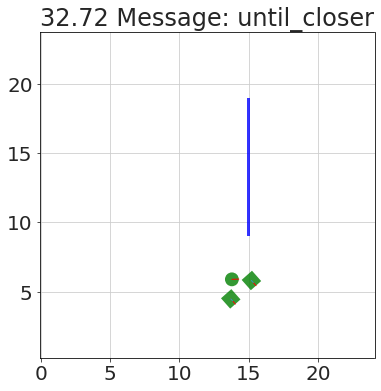

In [12]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)

robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

#Box(env,x=15,y=6,width=0.2,height=10)   # should turn left
Box(env,x=15,y=14,width=0.2,height=10)  # should turn right
#Box(env,x=15,y=12,width=0.2,height=20)  # should back up

run_sim(env,robot.controller,
        figure_width=6,
       total_time=80,
       dt_display=0.5,  # make this larger for a faster display
       )

In [45]:
robot['center'].left_distance

4.208031654097794

In [46]:
robot['center'].right_distance

14.66369563473179